# 教師あり学習（線形回帰）

教師あり学習においては、トレーニング用データ例$\{x_{n},y_{n}\}$によって構築されラベル付けされたデータにより、隠された構造を推論することができる。線形回帰は連続した値として出力される$y$を一般的にに意味する。

我々は、Edward を用いた例をデモンストレーションする。 Jupyter notebook によるインタラクティブバージョンは下記にて提供する。
http://edwardlib.org/tutorials/supervised-regression.

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## データ

トレーニングと、テストセット用の４０データポイントによってシミュレーションしよう。入力として$\mathbf{X_{n}\in\mathbb{R^{\mathrm{10}}}}$と出力として$y_{n}\in\mathbb{R}$のペアによって構成される。標準正規分布の無作為なノイズの一次独立を持つ

In [3]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.random.normal(0.0, 2.0, size=(N, D))
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y


ed.set_seed(42)

N = 40  # データポイントの数
D = 10  # 特徴量の数

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

## モデル

モデルはベイジアン線形回帰 (Murphoy, 2012) とする。これは、入力の$\mathbf{x\in\mathbb{R^{\mathit{D}}}}$と出力の$y\in\mathbb{R}$間の直線相関を仮定する。

データセット$\boldsymbol{N}$、データポイント$(\mathbf{X,}y)=\{(\mathbf{x_{n},y_{n})\}}$このモデルは、下記の分布に従う:

\begin{align*}
  p(\mathbf{w})
  &=
  \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}),
  \\[1.5ex]
  p(b)
  &=
  \text{Normal}(b \mid 0, \sigma_b^2),
  \\
  p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X})
  &=
  \prod_{n=1}^N
  \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).
\end{align*}

潜在変数は線型モデルのウェイトであるwと切片であるbバイアスとしても知られている。$\sigma_{w}^{2},\sigma_{b}^{2}$は事前分布とみなし、$\sigma_{y}^{2}$は尤度の分散とする。尤度の平均は入力$\mathbf{x_{n}}$の線形写像として与えられる。

Edwardを用い、モデルを作る。$\sigma_{w},\sigma_{b},\sigma_{y}=1$とする。

In [4]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

プレースホルダー`Ｘ`を定義する。推定の間、データによる値をプレースホルダーに移す

## 推定

変分ベイズ推定を使い事後分布を推定する。ウェイトをすべて正規分布に従うものとして変分モデルを定義する。

In [5]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

カルバックライブラ情報量を指標に、$250$イテレータと$5$潜在変数サンプルを使い変分ベイズ推定を行う。

In [6]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 65.809


このケースでは、KLqp関数は標準で$\mathrm{KL(\mathit{q\mathrm{||}p)}}$情報量を再パラメタ勾配によって使い最小化する。
推定におけるより詳しい情報は, [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp) を参考にされたい.

## 批評

線形回帰のための評価基準は提供された "testing" データにおける予測の正確さを比較することによって可能である. 我々はこれを最初に型付けされた事後予測分布から行うことができる.

In [7]:
y_post = ed.copy(y, {w: qw, b: qb})
# これは次と等しい
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

これとともに、(事後予測の)モデルからの予測を使い、さまざまな量の評価を行うことができる.

In [8]:
print("テストデータにおける二乗誤差:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("テストデータにおける平均絶対誤差:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

テストデータにおける二乗誤差:
0.0295391
テストデータにおける平均絶対誤差:
0.130098


学習済みモデルは低いエラーの予測を出す（アウトプットの巨大さに相対して）.

我々は、(最初の特徴次元において)事前に生成されたデータと、事後に生成されたデータを比較することによって適合具合を視覚化することもできる.

In [9]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

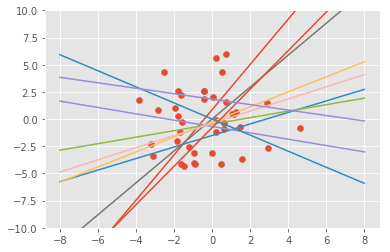

In [10]:
# 事前サンプルデータからの視覚化.
visualise(X_train, y_train, w, b, n_samples=10)

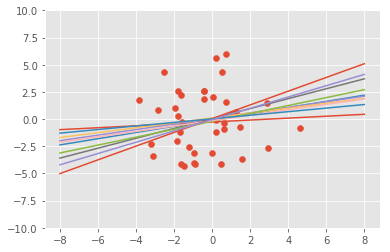

In [11]:
# 事後サンプルデータからの視覚化.
visualise(X_train, y_train, qw, qb, n_samples=10)

モデルは、$\mathbf{x}\in\mathbb{R}^D$ における最初の特徴次元とアウトプット$y\in\mathbb{R}$間の直線相関を学習した.